In [1]:
%load_ext autoreload
%autoreload 2

!conda install '/kaggle/input/pydicom-conda-helper/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/conda-4.10.1-py37h89c1867_0.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/openssl-1.1.1k-h7f98852_0.tar.bz2' -y --offline

!pip install '/kaggle/input/kerasapplications' --no-deps
!pip install '/kaggle/input/efficientnet-keras-source-code' --no-deps
!pip install '/kaggle/input/effdet-023-latest-vinbigdata-wbf-fusedlior/ensemble_boxes-1.0.4-py3-none-any.whl' --no-deps

## MMDetection compatible torch installation
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torch-1.7.0+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torchvision-0.8.1+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torchaudio-0.7.0-cp37-cp37m-linux_x86_64.whl' --no-deps

## Compatible Cuda Toolkit installation
!mkdir -p /kaggle/tmp && cp /kaggle/input/pytorch-170-cuda-toolkit-110221/cudatoolkit-11.0.221-h6bb024c_0 /kaggle/tmp/cudatoolkit-11.0.221-h6bb024c_0.tar.bz2 && conda install /kaggle/tmp/cudatoolkit-11.0.221-h6bb024c_0.tar.bz2 -y --offline

## MMDetection Offline Installation
!pip install '/kaggle/input/mmdetectionv2140/addict-2.4.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/yapf-0.31.0-py2.py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/terminal-0.4.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/terminaltables-3.1.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/mmcv_full-1_3_8-cu110-torch1_7_0/mmcv_full-1.3.8-cp37-cp37m-manylinux1_x86_64.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/pycocotools-2.0.2/pycocotools-2.0.2' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/mmpycocotools-12.0.3/mmpycocotools-12.0.3' --no-deps

!cp -r /kaggle/input/mmdetectionv2140/mmdetection-2.14.0 /kaggle/working/
!mv /kaggle/working/mmdetection-2.14.0 /kaggle/working/mmdetection
%cd /kaggle/working/mmdetection
!pip install -e . --no-deps
%cd /kaggle/working/


######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - don

In [2]:
import sys
sys.path.append('/kaggle/working/mmdetection')

import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import gc
import glob
import numpy as np
import random
import shutil

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Create Study and Image Level Dataframes</span>

In [3]:
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')

# Form study and image dataframes
sub_df['level'] = sub_df.id.map(lambda idx: idx[-5:])
study_df = sub_df[sub_df.level=='study'].rename({'id':'study_id'}, axis=1)
image_df = sub_df[sub_df.level=='image'].rename({'id':'image_id'}, axis=1)

dcm_path = glob.glob('/kaggle/input/siim-covid19-detection/test/**/*dcm', recursive=True)
test_meta = pd.DataFrame({'dcm_path':dcm_path})
test_meta['image_id'] = test_meta.dcm_path.map(lambda x: x.split('/')[-1].replace('.dcm', '')+'_image')
test_meta['study_id'] = test_meta.dcm_path.map(lambda x: x.split('/')[-3].replace('.dcm', '')+'_study')

study_df = study_df.merge(test_meta, on='study_id', how='left')
image_df = image_df.merge(test_meta, on='image_id', how='left')

# Remove duplicates study_ids from study_df
study_df.drop_duplicates(subset="study_id",keep='first', inplace=True)

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Fast or Full Predictions</span>

In case of non-competetion submission commits, we run the notebook with just two images each for image level and study level inference from the public test data.

In [4]:
fast_sub = False

if sub_df.shape[0] == 2477:
    fast_sub = True
    study_df = study_df.sample(2)
    image_df = image_df.sample(2)
    
    print("\nstudy_df")
    display(study_df.head(2))
    print("\nimage_df")
    display(image_df.head(2))
    print("\ntest_meta")
    display(test_meta.head(2))


study_df


,study_id,PredictionString,level,dcm_path,image_id
486,5be3004f3c87_study,negative 1 0 0 1 1,study,/kaggle/input/siim-covid19-detection/test/5be3...,30b1c089724e_image
411,4cbdd2d5ca8f_study,negative 1 0 0 1 1,study,/kaggle/input/siim-covid19-detection/test/4cbd...,c010822b2938_image



image_df


,image_id,PredictionString,level,dcm_path,study_id
929,b37ae8cb220b_image,none 1 0 0 1 1,image,/kaggle/input/siim-covid19-detection/test/1b11...,1b11175dece3_study
1172,e252ffbf487e_image,none 1 0 0 1 1,image,/kaggle/input/siim-covid19-detection/test/7f31...,7f3115e66c1e_study



test_meta


,dcm_path,image_id,study_id
0,/kaggle/input/siim-covid19-detection/test/2fb1...,a29c5a68b07b_image,2fb11712bc93_study
1,/kaggle/input/siim-covid19-detection/test/19c6...,9850b5470fd6_image,19c66935e737_study


In [5]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
STUDY_2_DIMS = (600, 600)
STUDY_3_DIMS = (640,640)
STUDY_DIMS = (768, 768)
IMAGE_DIMS = (512, 512)

study_dir = f'/kaggle/tmp/test/study/'
os.makedirs(study_dir, exist_ok=True)

image_dir = f'/kaggle/tmp/test/image/'
os.makedirs(image_dir, exist_ok=True)

def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im

for index, row in tqdm(study_df[['study_id', 'dcm_path']].iterrows(), total=study_df.shape[0]):
    # set keep_ratio=True to have original aspect ratio
    xray = read_xray(row['dcm_path'])
    im = resize(xray, size=STUDY_DIMS[0])
    im.save(os.path.join(study_dir, row['study_id']+'.png'))

image_df['dim0'] = -1
image_df['dim1'] = -1

for index, row in tqdm(image_df[['image_id', 'dcm_path', 'dim0', 'dim1']].iterrows(), total=image_df.shape[0]):
    # set keep_ratio=True to have original aspect ratio
    xray = read_xray(row['dcm_path'])
    im = resize(xray, size=IMAGE_DIMS[0])  
    im.save(os.path.join(image_dir, row['image_id']+'.png'))
    image_df.loc[image_df.image_id==row.image_id, 'dim0'] = xray.shape[0]
    image_df.loc[image_df.image_id==row.image_id, 'dim1'] = xray.shape[1]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
study_df['image_path'] = study_dir+study_df['study_id']+'.png'
image_df['image_path'] = image_dir+image_df['image_id']+'.png'

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Custom Wrapper for Loading TFHub Model trained in TPU</span>

Since the EffNetV2 Classifier models were trained on a TPU with the `tfhub.KerasLayer` formed with the handle argument as a GCS path, while loading the saved model for inference, the method tries to download the pre-trained weights from the definition of the layer from training i.e a GCS path.

Since, inference notebooks don't have GCS and internet access, it is not possible to load the model without the pretrained weights explicitly loaded from the local directory.

If the models were trained on a GPU, we can use the cache location method to load the pre-trained weights by storing them in a cache folder with the hashed key of the model location, as the folder name. I tried this method here but, it doesn't seem to work as the model was trained with a GCS path defined in the `tfhub.KerasLayer` and the method kept on hitting the GCS path rather than loading the weights from the cache location.

The only solution was to create a wrapper class to correct the handle argument to load the right pretrained weights explicitly from the local directory.

In [7]:
import tensorflow as tf
import tensorflow_hub as tfhub

MODEL_ARCH = 'efficientnetv2-l-21k-ft1k'
# Get the TensorFlow Hub model URL
hub_type = 'feature_vector' # ['classification', 'feature_vector']
MODEL_ARCH_PATH = f'/kaggle/input/efficientnetv2-tfhub-weight-files/tfhub_models/{MODEL_ARCH}/{hub_type}'

# Custom wrapper class to load the right pretrained weights explicitly from the local directory
class KerasLayerWrapper(tfhub.KerasLayer):
    def __init__(self, handle, **kwargs):
        handle = tfhub.KerasLayer(tfhub.load(MODEL_ARCH_PATH))
        super().__init__(handle, **kwargs)

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Predict Study Level</span>

In [8]:
import tensorflow.keras.backend as K
import math
SATURATION  = (0.9, 1.1)
CONTRAST = (0.9, 1.1)
BRIGHTNESS  =  0.1
ROTATION    = 10.0
SHEAR    = 2.0
HZOOM  = 8.0
WZOOM  = 4.0
HSHIFT = 4.0
WSHIFT = 4.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = STUDY_DIMS[0]
    XDIM = DIM%2
    
    rot = ROTATION * tf.random.normal([1], dtype='float32')
    shr = SHEAR * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM
    h_shift = HSHIFT * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT * tf.random.normal([1], dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])


def build_augmenter_V2(with_labels=True):
    
    def augment_v2(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_saturation(img, SATURATION[0], SATURATION[1])
        img = tf.image.random_contrast(img, CONTRAST[0], CONTRAST[1])
        img = tf.image.random_brightness(img, BRIGHTNESS)
        return img
    return augment_v2

In [9]:
MODEL_PATH = '/kaggle/input/siim-effnetv2-keras-study-train'
test_paths = study_df.image_path.tolist()
BATCH_SIZE = 16

def build_decoder(with_labels=True, target_size=(300, 300), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img

    def decode_with_labels(path, label):
        return decode(path), label

    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_flip_up_down(img)
        random_number = random.randint(0, 2)
        if random_number == 1:
            img = tf.image.adjust_brightness(img, 0.8)
        if random_number == 2:
            img = tf.image.adjust_brightness(img, 0.4)
        return img

    def augment_with_labels(img, label):
        return augment(img), label

    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,augment_V2=False,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
   
    if augment_V2 is True:
        augment_fn = build_augmenter_V2(labels is not None)
            
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)

    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(transform, num_parallel_calls=AUTO) if augment_V2 else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment_V2 else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)

    return dset

# strategy = auto_select_accelerator()
# BATCH_SIZE = strategy.num_replicas_in_sync * 16

label_cols = ['negative', 'typical', 'indeterminate', 'atypical']
study_df[label_cols] = 0



In [10]:

test_decoder = build_decoder(with_labels=False,
                             target_size=(STUDY_DIMS[0],
                                          STUDY_DIMS[0]), ext='png')
test_dataset = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False,augment_V2=False, cache=False,
    decode_fn=test_decoder
)



with tf.device('/device:GPU:0'):
    models = []
    model0 = tf.keras.models.load_model(f'{MODEL_PATH}/model0.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    model1 = tf.keras.models.load_model(f'{MODEL_PATH}/model1.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    model2 = tf.keras.models.load_model(f'{MODEL_PATH}/model2.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    model3 = tf.keras.models.load_model(f'{MODEL_PATH}/model3.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    model4 = tf.keras.models.load_model(f'{MODEL_PATH}/model4.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    models.append(model0)
    models.append(model1)
    models.append(model2)
    models.append(model3)
    models.append(model4)

In [11]:
import efficientnet.tfkeras as efn
test_decoder2 = build_decoder(with_labels=False,
                             target_size=(STUDY_2_DIMS[0],
                                          STUDY_2_DIMS[0]), ext='png')
test_dataset2 = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder2
)

with tf.device('/device:GPU:0'):
    models2 = []
     
    model5 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-study/model0.h5'
    )
    model6 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-study/model1.h5'
    )
    model7 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-study/model2.h5'
    )
    model8 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-study/model3.h5'
    )
    model9 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-study/model4.h5'
    )
    
    
    models2.append(model5)
    models2.append(model6)
    models2.append(model7)
    models2.append(model8)
    models2.append(model9)

In [12]:
test_decoder3 = build_decoder(with_labels=False,
                             target_size=(STUDY_3_DIMS[0],
                                          STUDY_3_DIMS[0]), ext='png')
test_dataset3 = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False,augment=False, augment_V2=False, cache=False,
    decode_fn=test_decoder3
)

with tf.device('/device:GPU:0'):
    models3 = []
     
    model10 = tf.keras.models.load_model(
        '/kaggle/input/ext-data-vinbig-augs/model0.h5'
    )
    model11 = tf.keras.models.load_model(
        '/kaggle/input/ext-data-vinbig-augs/model1.h5'
    )
    model12 = tf.keras.models.load_model(
        '/kaggle/input/ext-data-vinbig-augs/model2.h5'
    )
    model13 = tf.keras.models.load_model(
        '/kaggle/input/ext-data-vinbig-augs/model3.h5'
    )
    model14 = tf.keras.models.load_model(
        '/kaggle/input/ext-data-vinbig-augs/model4.h5'
    )
    
    
    models3.append(model10)
    models3.append(model11)
    models3.append(model12)
    models3.append(model13)
    models3.append(model14)

In [13]:
weights = {
    0: 3,
    1: 2,
    2: 2,
    3: 3,
    4: 2,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 2,
    10: 1,
    11: 1,
    12: 1,
    13: 2,
    14: 2
}

weights_sum = sum(weights.values())
weights = {k: v/weights_sum for k, v in weights.items()}

In [14]:
predictions2 = [model.predict(test_dataset2, verbose=1) for model in models2]
predictions3 = [model.predict(test_dataset3, verbose=1) for model in models3]

predictions = [model.predict(test_dataset, verbose=1) for model in models]
predictions = predictions + predictions2 + predictions3
for i, pred in enumerate(predictions):
    #print(i,pred)
    predictions[i] = weights[i] * pred
    
study_df[label_cols] = sum(predictions)  
#study_df[label_cols] = sum([model.predict(test_dataset, verbose=1) for model in models]) / len(models)
study_df['PredictionString'] = study_df[label_cols].apply(lambda row: f'negative {row.negative} 0 0 1 1 typical {row.typical} 0 0 1 1 indeterminate {row.indeterminate} 0 0 1 1 atypical {row.atypical} 0 0 1 1', axis=1)



1/1 [==============================] - 4s 4s/step


In [15]:
del models
del models2
del models3
del model0, model1,model2, model3, model4
del model5, model6, model7, model8, model9
del model10, model11, model12, model13, model14
del test_dataset, test_decoder
del test_dataset2, test_decoder2
del test_dataset3, test_decoder3
gc.collect()

5622563

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Predict 2Class Image Level</span>

Using [@Alien](https://www.kaggle.com/h053473666) 2class model.

In [16]:
import efficientnet.tfkeras as efn



test_paths = image_df.image_path.tolist()
image_df['none'] = 0
label_cols = ['none']

test_decoder = build_decoder(with_labels=False,
                             target_size=(IMAGE_DIMS[0],
                                          IMAGE_DIMS[0]), ext='png')
dtest = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder
)


with tf.device('/device:GPU:0'):
    models = []
    models0 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-fold05-2class/model0.h5'
    )
    models1 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-fold05-2class/model1.h5'
    )
    models2 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-fold05-2class/model2.h5'
    )
    models3 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-fold05-2class/model3.h5'
    )
    models4 = tf.keras.models.load_model(
        '/kaggle/input/siimcovid19efnb7-train-fold05-2class/model4.h5'
    )

    models5 = tf.keras.models.load_model(
        '/kaggle/input/tf-with-efficientnet-train-lior/model0.h5'
    )
    models6 = tf.keras.models.load_model(
        '/kaggle/input/tf-with-efficientnet-train-lior/model1.h5'
    )
    models7 = tf.keras.models.load_model(
        '/kaggle/input/tf-with-efficientnet-train-lior/model2.h5'
    )
    models8 = tf.keras.models.load_model(
        '/kaggle/input/tf-with-efficientnet-train-lior/model3.h5'
    )
    models9 = tf.keras.models.load_model(
        '/kaggle/input/tf-with-efficientnet-train-lior/model4.h5'
    )
    
    models10 = tf.keras.models.load_model(
        '/kaggle/input/efnb5-train-fold05-2class-lior/model0.h5'
    )
    models11 = tf.keras.models.load_model(
        '/kaggle/input/efnb5-train-fold05-2class-lior/model1.h5'
    )
    models12 = tf.keras.models.load_model(
        '/kaggle/input/efnb5-train-fold05-2class-lior/model2.h5'
    )
    models13 = tf.keras.models.load_model(
        '/kaggle/input/efnb5-train-fold05-2class-lior/model3.h5'
    )
    models14 = tf.keras.models.load_model(
        '/kaggle/input/efnb5-train-fold05-2class-lior/model4.h5'
    )
    
    
    models.append(models0)
    models.append(models1)
    models.append(models2)
    models.append(models3)
    models.append(models4)
    
    models.append(models5)
    models.append(models6)
    models.append(models7)
    models.append(models8)
    models.append(models9)
    
    models.append(models10) 
    models.append(models11)
    models.append(models12)
    models.append(models13)
    models.append(models14)


In [17]:

weights = {
    0: 3,
    1: 2,
    2: 1,
    3: 2,
    4: 2,
    5: 1,
    6: 2,
    7: 1,
    8: 1,
    9: 2,   
    10: 1,
    11: 1,
    12: 2,
    13: 2,
    14: 1
}

weights_sum = sum(weights.values())
weights = {k: v/weights_sum for k, v in weights.items()}

predictions = [model.predict(dtest, verbose=1) for model in models]
#predictions2 = [model.predict(test_dataset2, verbose=1) for model in models_2]
predictions = predictions#+predictions2
for i, pred in enumerate(predictions):
    predictions[i] = weights[i] * pred
    
image_df[label_cols] = sum(predictions)
#sub_df[label_cols] = sum([model.predict(dtest, verbose=1) for model in models]) / len(models)
image_df = image_df.reset_index(drop=True)


del models#,models_2
del models0, models1, models2, models3, models4
del models5, models6, models7, models8, models9
del models10, models11, models12, models13, models14
#del models15, models16, models17, models18, models19
del dtest, test_decoder
#del test_dataset2, test_decoder2
gc.collect()

1/1 [==============================] - 3s 3s/step


1202539

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Predict Image Level</span>

In [18]:
from numba import cuda
import torch
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7fb3eb857470 to Device at 0x7fb423fdc450>

In [19]:
from tqdm.notebook import tqdm

import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device.type)

import torchvision
print(torch.__version__, torch.cuda.is_available())

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check MMDetection installation
from mmdet.apis import set_random_seed

# Imports
import mmdet
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector

import mmcv
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from mmdet.apis import single_gpu_test
from mmdet.datasets import build_dataloader, build_dataset

cuda
1.7.0+cu110 True
11.0
GCC 7.3


In [20]:
import cv2
import matplotlib.pyplot as plt

label2color = [[59, 238, 119]]

viz_labels =  ["Covid_Abnormality"]

def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap=None):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap=None, img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    return fig
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_font = 0.6
    thickness = 8
    font_size = 2.0
    font_weight = 1
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_weight)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-18-text_height), (box[0]+text_width+8, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_font, output, 1 - alpha_font, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-12),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), font_weight, cv2.LINE_AA)
    return output

def draw_bbox_small(image, box, label, color):   
    alpha = 0.1
    alpha_text = 0.3
    thickness = 1
    font_size = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, thickness)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1 - alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)
    return output

In [21]:
baseline_cfg_path = "/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/job4_cascade_rcnn_x101_32x4d_fpn_1x_coco.py"
cfg = Config.fromfile(baseline_cfg_path)

cfg.classes = ("Covid_Abnormality")
cfg.data.test.img_prefix = ''
cfg.data.test.classes = cfg.classes

# cfg.model.roi_head.bbox_head.num_classes = 1
# cfg.model.bbox_head.num_classes = 1
for head in cfg.model.roi_head.bbox_head:
    head.num_classes = 1

# Set seed thus the results are more reproducible
cfg.seed = 211
set_random_seed(211, deterministic=False)
cfg.gpu_ids = [0]

cfg.data.test.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip', direction='horizontal'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='DefaultFormatBundle'),
                    dict(type='Collect', keys=['img'])
                ])
        ]

cfg.test_pipeline = [
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip', direction='horizontal'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='DefaultFormatBundle'),
                    dict(type='Collect', keys=['img'])
                ])
        ]

# cfg.data.samples_per_gpu = 4
# cfg.data.workers_per_gpu = 4
# cfg.model.test_cfg.nms.iou_threshold = 0.3
cfg.model.test_cfg.rcnn.score_thr = 0.001

WEIGHTS_FILE = ["/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold0_job4v0.pth"]
#WEIGHTS_FOLD1 ="/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold1_job4v0.pth"
WEIGHTS_FOLD1 ="/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold1_job4v0.pth"
#WEIGHTS_FOLD2 = '/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold2_job4v0.pth'
WEIGHTS_FOLD2 = '/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold2_job4v0.pth'

WEIGHTS_FOLD3 = "/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold3_job4v0.pth"
WEIGHTS_FOLD4 = '/kaggle/input/siim-covid-19-cascade-rcnn-x101-models-5-folds/models_files_cascade_rcnn_x101_32x4d_fpn_1x_fold4_job4v0.pth'
#WEIGHTS_FOLD5 = '/kaggle/input/siim-mmdetection-fnet-weight-bias/job4_cascade_rcnn_x101_32x4d_fpn_1x_fold4/epoch_2.pth'
WEIGHTS_FOLD5 ='/kaggle/input/siim-5-secbest-epochs-rcnn/epoch_8.pth'

WEIGHTS_FOLD6 ='/kaggle/input/siim-5-secbest-epochs-rcnn/epoch_10.pth'
WEIGHTS_FOLD7 ='/kaggle/input/siim-5-secbest-epochs-rcnn/epoch_11.pth'
WEIGHTS_FOLD8 ='/kaggle/input/siim-5-secbest-epochs-rcnn/epoch_9 (1).pth'
WEIGHTS_FOLD9 ='/kaggle/input/siim-5-secbest-epochs-rcnn/epoch_9.pth'

WEIGHTS_FILE.append(WEIGHTS_FOLD1)
WEIGHTS_FILE.append(WEIGHTS_FOLD2)
WEIGHTS_FILE.append(WEIGHTS_FOLD3)
WEIGHTS_FILE.append(WEIGHTS_FOLD4)
WEIGHTS_FILE.append(WEIGHTS_FOLD5)
WEIGHTS_FILE.append(WEIGHTS_FOLD6)
WEIGHTS_FILE.append(WEIGHTS_FOLD7)
WEIGHTS_FILE.append(WEIGHTS_FOLD8)
WEIGHTS_FILE.append(WEIGHTS_FOLD9)



options = dict(classes = ("Covid_Abnormality"))
models = []
for row in WEIGHTS_FILE:
    model = init_detector(cfg, row, device='cuda:0')
    model.to(device)
    model.eval()
    models.append(model)

/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [22]:
with_Yolo = False

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
if with_Yolo:
    split = 'test'
    dim = 512 #1024, 256, 'original'
    test_dir = f'/kaggle/tmp/{split}/image'
    weights_dir = '/kaggle/input/weights-of-yolov5-150-epochslior/best.pt'

    shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
    os.chdir('/kaggle/working/yolov5') # install dependencies

In [24]:
if with_Yolo:
    !python detect.py \
    --weights $weights_dir \
    --img 512\
    --conf 0.01\
    --iou 0.5\
    --augment\
    --source $test_dir\
    --name infer_fold \
    --save-txt --save-conf --exist-ok



In [25]:
if with_Yolo:
    labelpaths = glob.glob("runs/detect/infer_fold/labels/*")

In [26]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]

    """ 
    max_size = max(image_height,image_width)
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int

    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes/max_size

In [27]:
if with_Yolo:
    image_ids = []
    score = []
    box = []
    for file_path in tqdm(labelpaths):
        image_id = file_path.split('/')[-1].split('.')[0]
        w, h = image_df.loc[image_df.image_id==image_id,['dim1', 'dim0']].values[0]
        f = open(file_path, 'r')
        data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
        data = data[:, [0, 5, 1, 2, 3, 4]]
        data = np.concatenate([data[:, :2], yolo2voc(h, w, data[:, 2:])], axis =1)

        #if fast_sub:
        #    predbox_ens.append(norm2hw(h, w, data[:,2:]))


        image_ids.append(image_id)
        score.append(data[:,1])
        box.append(data[:,2:])

    pred_df_yolo = pd.DataFrame({'id':image_ids,'score':score,'label':0,'box':box})

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Ensemble Image Level</span>

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/kaggle/working/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/kaggle/working/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


  0%|          | 0/10 [00:00<?, ?it/s]

/kaggle/working/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/kaggle/working/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


,id,PredictionString
1,e252ffbf487e_image,opacity 0.1447689235210419 544 865 861 1607 op...
0,b37ae8cb220b_image,opacity 0.5935409069061279 1804 919 2276 2130 ...


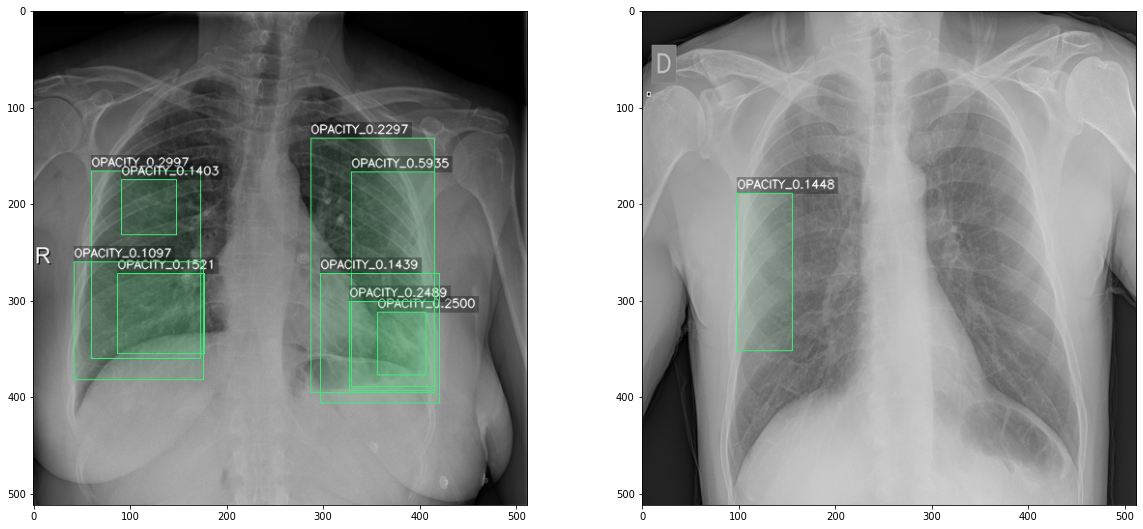

In [28]:
from ensemble_boxes import weighted_boxes_fusion, nms

viz_images = []
results = []
score_threshold = cfg.model.test_cfg.rcnn.score_thr

def format_pred(boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray) -> str:
    pred_strings = []
    label_str = ['opacity']
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label_str[int(label)]} {score:.16f} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)



viz_images = []

with torch.no_grad():
    for index, row in tqdm(image_df.iterrows(), total=image_df.shape[0]):
        predictions = []
        boxes, scores, labels = (list(), list(), list())
        for model in tqdm(models):
            original_H, original_W = (int(row.dim0), int(row.dim1))
            max_size = max(original_H,original_W)
            prediction = inference_detector(model, row.image_path)
            predictions.append(prediction)
        for k, cls_result in enumerate(predictions):
            cls_result = cls_result[0]
            if cls_result.size != 0:
                boxes.append(cls_result[:, :4]/max_size)
                scores.append(cls_result[:, 4])
                labels.append([0]*len(cls_result[:, 4]))
        if with_Yolo:
            index = pred_df_yolo[pred_df_yolo.id==row.image_id].index
            yolorow = pred_df_yolo.iloc[index]
            boxes_y = yolorow.box.values[0].tolist()
            scores_y = yolorow.score.values[0].tolist()
            labels_y =  yolorow.label.values.tolist()*len(scores_y)
            boxes.append(boxes_y)
            scores.append(scores_y)
            labels.append(labels_y)
        #weights=[1,1,1,1,1,1,1,1,1,1,2]
        boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, iou_thr=0.65,skip_box_thr=0.00)           
        boxes*=max_size
        if fast_sub:
            img_viz = cv2.imread(row.image_path)
            for box, label, score in zip(boxes, labels, scores):
                if score>0.1:
                    color = label2color[int(label)]
                    img_viz = draw_bbox_small(img_viz, box.astype(np.int32), f'opacity_{score:.4f}', color)
            viz_images.append(img_viz)

        if len(labels) != 0:
            h_ratio = original_H/IMAGE_DIMS[0]
            w_ratio = original_W/IMAGE_DIMS[1]
            boxes[:, [0, 2]] *= w_ratio
            boxes[:, [1, 3]] *= h_ratio

            result = {
                "id": row.image_id,
                "PredictionString": format_pred(
                    boxes, scores, labels
                ),
            }

            results.append(result)

detection_df = pd.DataFrame(results, columns=['id', 'PredictionString'])

if fast_sub:
    display(detection_df.sample(2))
    # Plot sample images
    plot_imgs(viz_images, cmap=None)
    plt.savefig('viz_fig_siim.png', bbox_inches='tight')
    plt.show()

In [29]:
del models
gc.collect()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19149

In [30]:
detection_df = detection_df.merge(image_df[['image_id', 'none']].rename({'image_id':'id'}, axis=1),
                                  on='id', how='left')

for i in range(detection_df.shape[0]):
    if detection_df.loc[i,'PredictionString'] != 'none 1 0 0 1 1':
        detection_df.loc[i,'PredictionString'] = detection_df.loc[i,'PredictionString'] + ' none ' + str(detection_df.loc[i,'none']) + ' 0 0 1 1'
detection_df = detection_df[['id', 'PredictionString']]

results_df = study_df[['study_id', 'PredictionString']].rename({'study_id':'id'}, axis=1)
results_df = results_df.append(detection_df[['id', 'PredictionString']])

In [31]:
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')
sub_df['PredictionString'] = np.nan
sub_df = sub_df.set_index('id')
results_df = results_df.set_index('id')
sub_df.update(results_df)
sub_df = sub_df.reset_index()
sub_df = sub_df.fillna("none 1 0 0 1 1")
sub_df.to_csv('/kaggle/working/submission.csv', index=False)

if fast_sub:
    display(sub_df.head(2))

,id,PredictionString
0,00188a671292_study,none 1 0 0 1 1
1,004bd59708be_study,none 1 0 0 1 1


In [32]:
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')
sub_df['PredictionString'] = np.nan
# sub_df = sub_df.set_index('id')
sub_df.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,PredictionString
0,00188a671292_study,NaN
1,004bd59708be_study,NaN
2,00508faccd39_study,NaN
3,006486aa80b2_study,NaN
4,00655178fdfc_study,NaN


In [33]:
!rm -r /kaggle/working/mmdetection

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.4em; font-weight: 300;">HAVE A GREAT DAY!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.4em; font-weight: 300;">Let me know if you have any suggestions!</span></p>